# Card Game Simulation



<img src="https://upload.wikimedia.org/wikipedia/commons/4/42/Playing_cards_collage.jpg"
     width="500"
     height="300">


## Goal

We play a card game where cards are iteratively flipped until we tell the dealer to stop.  
Then one additional card is flipped. If that card is **red**, we win \$1; otherwise we lose \$1.

Our goal is to discover a strategy that best predicts a red card in the deck.

---

## Plan

The following are the steps in order to achieve this:

1. Develop multiple strategies for predicting red cards in a randomly shuffled deck.
2. Apply each strategy across multiple simulations to compute its probability of success within a high confidence interval.
3. Return the simplest strategy associated with the highest probability of success.


## Packages

In [18]:
import numpy as np
import matplotlib.pyplot as plt


<a name='1'></a>
## 1 -  Predicting red cards in a shuffled deck

In [19]:
# we start by creating a deck holding 26 red cards and 26 black cards. 
# Black cards are represented by 0s and red by 1s
red_cards = 26 * [1]
black_cards = 26 * [0]
unshuffled_deck = red_cards + black_cards

In [20]:
# Shuffle a deck
np.random.seed(1)
shuffled_deck = np.random.permutation(unshuffled_deck)


Now we iteratively flip over the cards in the deck, stopping when the next card is more likely to be red.
One simple strategy is to terminate the game when the number of red cards remaining in the deck is greater than the number of black cards remaining the the deck.

In [21]:
remaining_red_cards = 26
for i, card in enumerate(shuffled_deck[:-1]):
    remaining_red_cards -= card 
    remaining_total_cards = 52 - i - 1
    if remaining_red_cards / remaining_total_cards >0.5:
        break
print(f"Stopping the game at index {i}.")
final_card = shuffled_deck[i+1]
color = 'red' if final_card else 0
print(f"The next card in the deck is {'red' if final_card else 'black'}.")
print(f" We have {'won' if final_card else 'lost'} !")

Stopping the game at index 0.
The next card in the deck is red.
 We have won !


The strategy halts when the fraction of remaining red cards is greater than half of the remaining total cards. Let's generalize card game strategy

In [22]:
np.random.seed(0)
total_cards = 52
total_red_cards =26
def execute_strategy(min_fraction_red = 0.5, shuffled_deck=None,return_index=False):
    if shuffled_deck is None:
        shuffled_deck = np.random.permutation(unshuffled_deck)
    remaining_red_cards = total_red_cards
    for i, card in enumerate(shuffled_deck[:-1]):
        remaining_red_cards -= card
        fraction_red_cards = remaining_total_cards / (total_cards - i - 1)
        if fraction_red_cards > min_fraction_red:
            break
    if return_index:
        return i + 1, shuffled_deck[i+1]
    else:
        return shuffled_deck[i+1]

<a name='1.1'></a>
### 1.1 -  Estimating the probability of strategy success

Let's apply this strategy to a series of 1000 random shuffles

In [ ]:
np.random.seed(0)
observations = np.array([execute_strategy() for _ in range(1000)])
# the total fraction of 1s in the observations corresponds to the observed fraction of red cards and therefore to the fraction of wins.
frequency_wins = observations.sum()/1000
assert frequency_wins == observations.mean()
print(f"The frequency of wins is {frequency_wins}")

The frequency of wins is 0.508


This strategy appears to be working 50.8% of the total games.
The total profit is:

In [29]:
dollars_won = frequency_wins * 1000
dollars_lost = (1-frequency_wins) * 1000
total_profit = dollars_won - dollars_lost
print(f"Total profit is ${total_profit:.2f}")

Total profit is $16.00


/var/folders/lq/m0kxqttn3ylcjp4lwypvrqfh0000gn/T/ipykernel_1293/3959324664.py:4: RuntimeWarning: Mean of empty slice.
  return observations.mean()


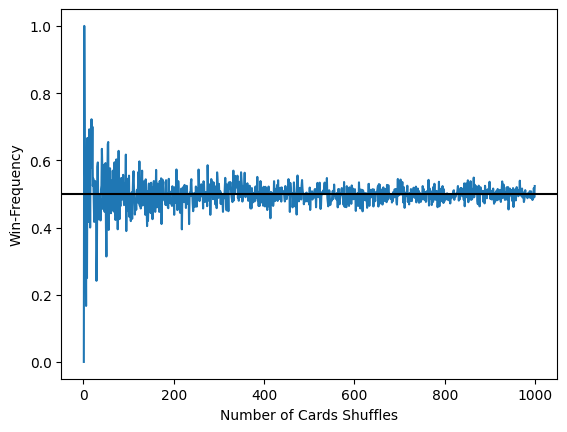

The win-frequency for 10,000 shuffles is 0.5235235235235235


In [35]:
np.random.seed(0)
def repeat_game(number_repeats):
    observations = np.array([execute_strategy () for _ in range(number_repeats)])
    return observations.mean()

frequencies = []
for i in range (0,1000):
    frequencies.append(repeat_game(i))

plt.plot(list(range(0,1000)),frequencies)
plt.axhline(0.5, color = 'k')
plt.xlabel('Number of Cards Shuffles')
plt.ylabel("Win-Frequency")
plt.show()
print(f"The win-frequency for 10,000 shuffles is {frequencies[-1]}")

The strategy yields a win frequency above 50% when 10_000 card shuffles are sampled. 
However, the strategy also fluctuates above and below 50% throughout the entire sampling process. 
How confident are we that the probability of a win is actually greater than 0.5.
We can find out using confidence interval analysis. We compute the confidence interval by sampling 10_000 card shuffles 300 times for a total of 3 million shuffles.

In [37]:
def compute_high_confidence_interval(likelihoods, bin_width):
    peak_index = likelihoods.argmax()
    area = likelihoods[peak_index] * bin_width
    start_index, end_index = peak_index, peak_index + 1
    while area < 0.95:
        if start_index > 0:
            start_index -= 1
        if end_index < likelihoods.size - 1:
            end_index += 1
        area = likelihoods[start_index: end_index + 1].sum() * bin_width
    range_start, range_end = bin_edges[start_index], bin_edges[end_index]
    range_string = f"{range_start:.6f} - {range_end:.6f}"
    print((f"The frequency range {range_string} represents a " 
           f"{100 * area:.2f}% confindence interval"))
    return start_index, end_index

The frequency range 0.489962 - 0.510269 represents a 98.33% confindence interval


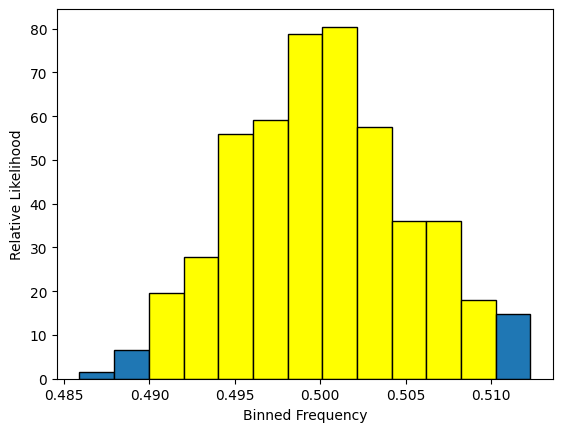

In [38]:
np.random.seed(0)
frequency_array = np.array([repeat_game(10000) for _ in range(300)])
likelihoods, bin_edges, patches = plt.hist(frequency_array,bins='auto',edgecolor='black',density=True)
bin_width = bin_edges[1] - bin_edges[0]
start_index, end_index = compute_high_confidence_interval(likelihoods, bin_width)
for i in range(start_index, end_index):
    patches[i].set_facecolor("yellow")
plt.xlabel("Binned Frequency")
plt.ylabel("Relative Likelihood")
plt.show()